# Insight Data Challenge #3 
## Employee Retention
Ying Ma
07/19/2018

### Goal
Employee turnover is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months. In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.

### Challenge Description
We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.
As said above, the goal is to predict employee retention and understand its main drivers

# 1. Loading data
Load the data as DataFrame, get initial idea of what data look like

In [1]:
# loading packages
from lifelines import CoxPHFitter #survival analysis library
from lifelines import KaplanMeierFitter 

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('/home/ying/18B/Data-Challenge-3/employee_retention.csv',index_col=0)

In [3]:
df.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34702 entries, 0 to 34701
Data columns (total 7 columns):
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null object
quit_date      23510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 2.1+ MB


### Initial Observations
1. Missing values in 'quit_date' represents the employee is still on job. 
2. Around 250 missing values in salary. 
3. A few data type needs to be adjusted.
4. 'temp_contractor' in dept tends to have a employee_id like 100xxxx, seriority = 0 and join_date prior of 2011. Need to look into this category.

## 2. Pre-processing
Cleaning the data. Adjusting for datatypes. Imputation as needed.

### 2.1 Employee_id
This data is supposed to be int object rather than float

In [5]:
df.employee_id = df.employee_id.astype(int)

### 2.2 Company_id
company_id is modeled as a categorical variable

In [6]:
df.company_id = df.company_id.astype('category')
df.company_id.value_counts()

1     9501
2     5220
3     3773
4     3066
5     2749
6     2258
7     2185
8     2026
9     2005
10    1879
12      24
11      16
Name: company_id, dtype: int64

### 2.3 dept
dept is modeled as categorical variable as well

In [7]:
df.dept = df.dept.astype('category')
df.dept.value_counts()

temp_contractor     10000
customer_service     9180
engineer             4613
data_science         3190
sales                3172
marketing            3167
design               1380
Name: dept, dtype: int64

### 2.4 Seniority
In here, seniority seems to be an integer number. I assume the number represents how many years of experience they have. Therefore, this variable is modeled as a continuous variable, where larger number indicates seniority in the position.<br>
However, let me check how many different seniority levels there are.

In [8]:

df.seniority.astype('category').value_counts(sort = False)

0     10000
1       861
2       942
3       881
4       895
5       936
6       950
7       928
8      1008
9       944
10      927
11      924
12      988
13      894
14      920
15      911
16      936
17      893
18      872
19      910
20      844
21      782
22      764
23      785
24      743
25      715
26      694
27      642
28      585
29      626
98        1
99        1
Name: seniority, dtype: int64

In [9]:
df.loc[df.seniority>30]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
23683,97289,10,engineer,98,266000.0,2011-12-13,2015-01-09
26543,604052,1,marketing,99,185000.0,2011-07-26,2013-12-06


In [10]:
df = df.drop(df.index[df.seniority>30])

These two people's data is deprecated on the seniority level. If there's more time or more missing data, I can try to impute the seniority based on the company, dept and salary. In here, I will directly drop these two data points.

###  2.5 salary
Less than 1% of entries don't have salary value. I will try to impute these values if there's more time, but for now I will drop these rows.

In [11]:
df = df.drop(df.index[df.salary.isna()])

In [12]:
#imp = Imputer(missing_values='NaN', strategy='median')
#imp.fit(df.iloc[:,1:5]);

### 2.6 join_date and quit_date
Convert these two variables to 'datetime' datatype.

In [13]:
df.join_date = pd.to_datetime(df.join_date)
df.quit_date = pd.to_datetime(df.quit_date)

### 2.7 About 'temp_contractor'
There are a fairly large number of temporary contractor in the data set. Contractors tends to have shorter period of employment duration, which is reflected in the data. Moreover, contract based employment duration is largely determined by the contract term itself, rather than the salary or the seniroity of the contractor. <br>
In fact, all the 'temp_contractor' has 0 seniority level.

In [14]:
df['seniority'].loc[df.dept == 'temp_contractor'].value_counts()

0    10000
Name: seniority, dtype: int64

In [15]:
df = df.drop(df.index[df.dept == 'temp_contractor'])

Tempororay contractors have different system of hiring and payment. Moreover, the impact of the turnover of short-term contractors is not as costly as long-term employees, because it's relatively easy to find a replacement for contractors. Therefore, the contractors shouldn't be incorporated into the analysis of employee's churning. Additionaly analysis can be done to determine how to maintain the relationship with contractors or how to determine the payment for contractors, but it should be another idenpendent analysis based soley on the data of contractors.

# 3. survival analysis
The problem of churning is a classical application of survival analysis. Survival models relate the time that passes before some event occurs. In here, the retention of the employees is modeled as target event and the employment duration can be treated as time to event or survival time. <br> <br>

 Another important concept of survival analysis is when the employees are still at their jobs at the end of the study, these observations are called censored meaning they've survived the study. Censoring is an important issue in survival analysis, representing a particular type of missing data. Survival analysis are designed to handle the event censorship flawlessly and this is also the reason why I chose survival analysis over other odinary linear regression model. <br> <br>

While there are many models for survival analysis, I chose Cox proportional hazards regression model because it provides interpretion regarding the relationship of the hazard function to predictors. In this data set specifically, I want to find out the whether company, department, seniority and salary will affect the churning rate of the employees.

### 3.1 pre-process for survival analysis
In order to perform the survival analysis, some pre-processing to determine employment duration and churning or not is necessary

In [16]:
# initialize the empty dataframe
df_cox = pd.DataFrame()

#### churning or not
define churning as 1 if the person already quit (have a quit date)

In [17]:
# define churning as 1 if the person already quit (have a quit date)
df_cox["churning"] = (~df.quit_date.isnull())

#### Survival duration
The survival duration is the time difference betwen join_date and quit_date. if the person is still at the company, I will use the last date of this study 2015/12/13 as the quit_date.

In [18]:
# fill the quit_date with the last date
df["quit_date_fill"] = df.quit_date
pd.to_datetime('2015/12/13')
df['quit_date_fill'].loc[df.quit_date_fill.isnull()]=pd.to_datetime('2015/12/13')

# calculate the duration between join and quit date
df_cox['duration'] = (df.quit_date_fill - df.join_date).dt.days

/home/ying/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Turning categorical variables to numbers

In [19]:
labelencoder=LabelEncoder()
df_cox['dept'] = labelencoder.fit_transform(df.dept)
df_cox['company_id'] = df.company_id.astype(int)
df_cox['seniority'] = df.seniority
df_cox['salary'] = df.salary

### 3.2 Fitting Cox Regression

In [20]:
cph = CoxPHFitter()
cph.fit(df_cox, duration_col = 'duration', event_col = 'churning', show_progress = True, )

Iteration 1: norm_delta = 0.16807, step_size = 0.95000, ll = -120949.41961, seconds_since_start = 0.6
Iteration 2: norm_delta = 0.01577, step_size = 0.95000, ll = -120859.36757, seconds_since_start = 1.3
Iteration 3: norm_delta = 0.00089, step_size = 0.95000, ll = -120858.49256, seconds_since_start = 1.9
Iteration 4: norm_delta = 0.00004, step_size = 0.95000, ll = -120858.48981, seconds_since_start = 2.4
Iteration 5: norm_delta = 0.00000, step_size = 0.95000, ll = -120858.48980, seconds_since_start = 3.0
Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 24461 observations, 11084 censored>

In [21]:
cph.print_summary()

n=24461, number of events=13377

              coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
dept        0.0285     1.0289    0.0050   5.7041 0.0000      0.0187      0.0383  ***
company_id -0.0018     0.9982    0.0033  -0.5591 0.5761     -0.0082      0.0046     
seniority   0.0113     1.0114    0.0014   8.3688 0.0000      0.0087      0.0139  ***
salary     -0.0000     1.0000    0.0000 -13.0533 0.0000     -0.0000     -0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.533
Likelihood ratio test = 181.860 on 4 df, p=0.00000


### 3.3 Iiterpretation of survival analysis

The summary of the Cox regression analysis shows that the department, seniority and salary have a really low p-value and therefore are highly correlated with churning. This is to say that the churning problem is not company-specific and the employees at different companies have equal probability of quitting. <br> 
Even though the key contributing factors of churning are identified, how the sub-categories, i.e. engineers vs. design are affected is unknown, and this will be explored next. 

# 4. Explore the sub-group difference


Kaplan-Meier curves allow us to estimate the "survival function" of one or more groups. In here, I apple Kaplan-Meier model to each sub-categorical features to visualize which sub-group is subjected to the risk of churning.

### 4.1 Company
The previous results have shown that the company doesn't have a significant influence on the employee's retention problem. In here, I will apply the KM analysis as a proof of concept.

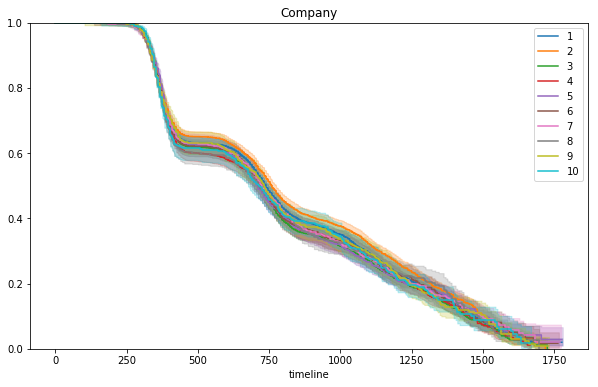

In [22]:
T = df_cox["duration"]
E = df_cox["churning"]
kmf = KaplanMeierFitter()

kmf.fit(T, event_observed=E)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for i in df_cox.company_id.value_counts().keys()[:10]:
    dem = (df_cox["company_id"] == i)
    kmf.fit(T[dem], event_observed=E[dem])
    kmf.plot(ax=ax, ci_force_lines=False)

plt.legend(df_cox.company_id.value_counts().keys()[:10])
plt.ylim(0, 1);
plt.title('Company');
#plt.title("Lifespans of different global regimes");

Company 11 and 12 have less employees and noisy curve, which are note illustrated here. For the rest of companies, we can observed that the survival curves are largely overlapped with each other, and therefore reconfirms that the churning problem is not related to which company the employees come from.<br>
<br>
Another observation is that there's a huge drop on the survival rate around the end of first year and another drop towards the end of second year. After two years the survival rate decreases linearly.


If the companies want to keep the employees, they could try to infuence  their employees (such as promotion or increase salary) around first two year's mark when the employees are considering switching jobs. After two years the employees may leave at anytime. 

### 4.2 Department
Kaplan-Meier curves were plotted across 6 departments to observe the difference of survival rate among departments. 

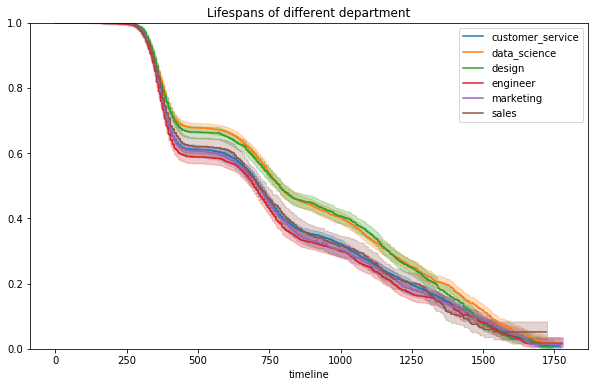

In [23]:
T = df_cox["duration"]
E = df_cox["churning"]

kmf.fit(T, event_observed=E)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for i in df_cox.dept.value_counts().keys():
    dem = (df_cox["dept"] == i)
    kmf.fit(T[dem], event_observed=E[dem])
    kmf.plot(ax=ax, ci_force_lines=False)

plt.legend(labelencoder.classes_)
plt.ylim(0, 1);
plt.title("Lifespans of different department");


The curves show that the 'data science' and 'design' department has lower retension across the board while 'engineer' department has higher mobility. Special care  is needed for engineers in order to keep them around longer.

### 4.3 Seniority level
Because there're around 30 different seniority level, the seniority level is first binned into 6 categories in order to better illustrate the survival curve.

In [24]:
# derive interval list# deriv 
seniority_bin_labels = [ "{} - {}".format(i, i + 4) for i in range(1, 30, 5) ]
print('seniority bins:')
print(seniority_bin_labels)
seniority_bins = pd.cut(df_cox.seniority, range(1, 32, 5), right=False, labels=seniority_bin_labels)


seniority bins:
['1 - 5', '6 - 10', '11 - 15', '16 - 20', '21 - 25', '26 - 30']


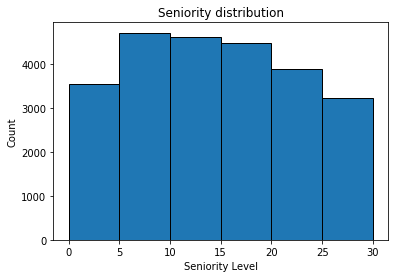

In [25]:
plt.hist(df_cox.seniority, bins = range(0, 31, 5), edgecolor='k');
plt.xlabel('Seniority Level');
plt.ylabel('Count');
plt.title('Seniority distribution');

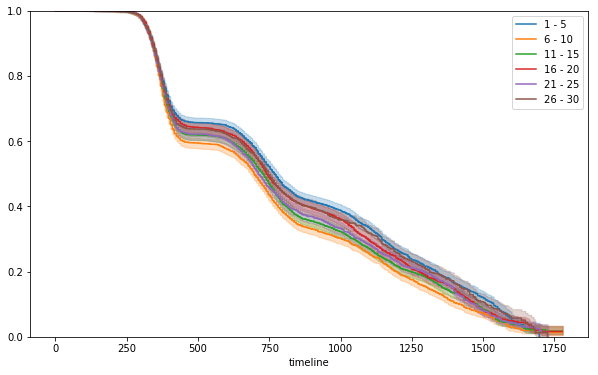

In [26]:
T = df_cox["duration"]
E = df_cox["churning"]

kmf.fit(T, event_observed=E)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for i in seniority_bin_labels:
    dem = (seniority_bins == i)
    kmf.fit(T[dem], event_observed=E[dem])
    kmf.plot(ax=ax, ci_force_lines=False)

plt.legend(seniority_bin_labels)
plt.ylim(0, 1);
#plt.title("Lifespans of different global regimes");


The retention of employees at different seniority level is not as different as in the departments. However, the most unstable seniority level is 6-10 and the most stable group is the most junior group. 

### 4.4 salary
Using techniques mentioned above, the salary can be binned into 6 categories

In [27]:
# create bins for salary range
lss = list(range(0, 250001, 50000))+[400000]

In [28]:
# derive interval list# deriv 
salary_bin_labels = [ "{} - {}".format(lss[i-1], lss[i]) for i in range(1,len(lss)) ]
print('salary bins')
print(salary_bin_labels)
salary_bins = pd.cut(df_cox.salary, lss, right=False, labels=salary_bin_labels)


salary bins
['0 - 50000', '50000 - 100000', '100000 - 150000', '150000 - 200000', '200000 - 250000', '250000 - 400000']


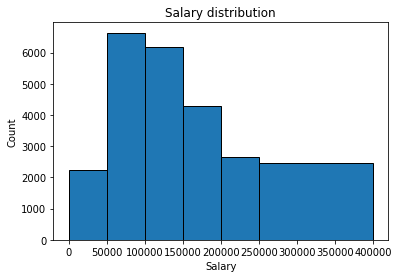

In [29]:
plt.hist(df_cox.salary, lss, edgecolor = 'k');
plt.xlabel('Salary');
plt.ylabel('Count');
plt.title('Salary distribution');

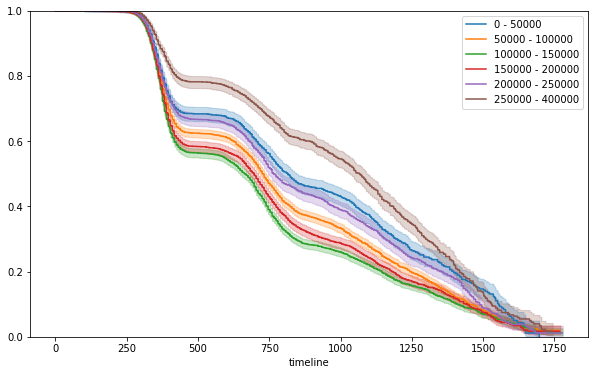

In [30]:
T = df_cox["duration"]
E = df_cox["churning"]

kmf.fit(T, event_observed=E)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for i in salary_bin_labels:
    dem = (salary_bins == i)
    kmf.fit(T[dem], event_observed=E[dem])
    kmf.plot(ax=ax, ci_force_lines=False)

plt.legend(salary_bin_labels)
plt.ylim(0, 1);


It is obvious that the most stable group has the highest salary. The most unstable group has salary ranging from 100k-150k, followed by group 150k-200k. 

# 5. Summary


According to the result of Cox regression, 'department', 'seniority' and 'salary' are the main factors that drive employee's churning. Which company the employee works at doesn't make a difference on the retension.

The department of engineer, seniority level at 6-10 and salary level around 100k-150k have a higher risk of retension and the employers should pay special attension to these groups.

The churning rates are high towards the end of the first and the second year, while few people quit before year 1 or between 1-2 years. The end of the first and the second year are the key time points where the company should try to 'woo' the employees. After 2 years, the retension rate drops linearly which suggests that the employees may leave at any point after two years. 

To better explain employee churning, additional features such as employee's position and satisfaction/happiness are needed. <br> <br>
In addition, the employees' salary and seriority level could have changed across the 4 years' study period. Assuming that the data provided here are the employees' status at 2015/12/13, the previous states are unknown. The churning could be caused by the dissatisfaction of salary/position progression at the company and the information about the promotion is missing here.